In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict

In [2]:
load_dotenv(override=True)

True

Setup LangSmith credentials and generate API keys over here: https://langsmith.com

In [4]:
# wrapper function for the serper developer tool
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")

'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris, the capital city of France, is often referred to as the “City of Light” (La Vi

In [5]:
# converting functions into tools
from langchain.agents import Tool

tool_search =Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need more information from an online search"
    )

In [6]:
# trial run
tool_search.invoke("What is the capital of Paraguay?")

'Asunción is the capital and the largest city of Paraguay. The city stands on the eastern bank of the Paraguay River, almost at the confluence of this river ... Asunción, city and capital of Paraguay, occupying a promontory and descending to the Paraguay River near its confluence with the Pilcomayo. Asunción is the capital of Paraguay as well as its political, economic, and cultural hub. Sometimes called the "Mother of Cities," Asunción served historically ... Asuncion is the capital of Paraguay. To learn more about Paraguay and its capital, click on the map below. The Shocking Truth about PARAGUAY\'S CAPITAL City - ASUNCION - A City of Two Halves! · Comments. Its capital and largest city is Asunción. Republic of Paraguay. República del Paraguay (Spanish); Paraguái Tavakuairetã ( ... The vast majority of the people live in the eastern region, most within 160 kilometers (100 mi.) of Asuncion, the capital and largest city. Keep reading for a brief summary on the highlights of Asunción, P

In [7]:
# writing a custom tool
import os
import requests

pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [8]:
tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

tool_push.invoke("Hello, me")

In [9]:

tools = [tool_search, tool_push]

## Building the graph

In [10]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [11]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [20]:
# Step 3: Create a node

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [21]:
# Step 4: Create Edges
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

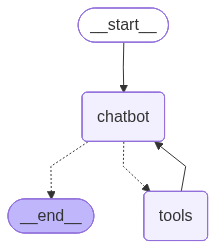

In [22]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content

In [24]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


This is a crucial point for understanding LangGraph
> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.

One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

## Building graph with memory

In [25]:
# adding checkpoints to the graph
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

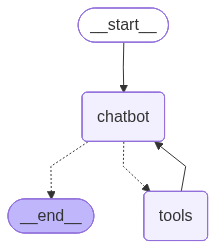

In [26]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory) # passing the memory object
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
config = {"configurable": {"thread_id": "1"}} # thread_id refers to the conversation thread particularly referencing the thread number '1'

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='1bfd1120-6f22-41c3-a2ae-a04259d0e4f5')]}
{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='1bfd1120-6f22-41c3-a2ae-a04259d0e4f5'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CdnjQyG8YauNNa3TTaZB4SBIQg8xT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b7e0b83f-187e-454f-88d8-50d44cbbdd17-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_tok

In [28]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='1bfd1120-6f22-41c3-a2ae-a04259d0e4f5'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CdnjQyG8YauNNa3TTaZB4SBIQg8xT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b7e0b83f-187e-454f-88d8-50d44cbbdd17-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage

In [30]:
# Most recent first

list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='1bfd1120-6f22-41c3-a2ae-a04259d0e4f5'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CdnjQyG8YauNNa3TTaZB4SBIQg8xT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b7e0b83f-187e-454f-88d8-50d44cbbdd17-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessag

LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

## Storing the memory in SQL

In [12]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

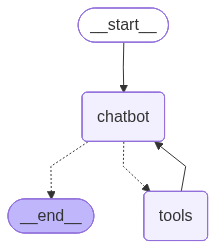

In [13]:
# Steps 1 and 2
graph_builder = StateGraph(State)

# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi there!', additional_kwargs={}, response_metadata={}, id='6618f9b7-8c72-4f20-ad6c-44933f970e76'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 91, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-Cdo2yDoKBKSmgC0TDlqMrLpzkKsF8', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--488d3819-4eb7-4603-b3b1-2e77d223f5a8-0', usage_metadata={'input_tokens': 91, 'output_tokens': 10, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Do yo